
# Euler's Method for Projectile Motion (No Air Resistance)

**Euler's method** to simulate a projectile launched near Earth's surface **without air resistance**, and compares numerical results to the **analytic solution** under constant gravity.

- Set initial conditions and a time step `Δt`.
- Run Euler's method and compare the trajectory against the analytic solution.
- Detect landing and compute the **range** numerically; compare to analytic range.
- Explore time-step sensitivity: sweep `Δt` and examine **landing-range error vs `Δt`**.
- Plot **position errors vs time**, **velocity/acceleration components**, and **mechanical energy** to assess algorithm behavior.


In [2]:

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUTDIR = "euler_outputs"
os.makedirs(OUTDIR, exist_ok=True)
%matplotlib inline


## Parameters

In [3]:

g = 9.81        # m/s^2
y0 = 0.0        # m
v0 = 40.0       # m/s
theta_deg = 40  # degrees

theta = math.radians(theta_deg)
vx0 = v0 * math.cos(theta)
vy0 = v0 * math.sin(theta)

dt = 0.01
t_max = 2.5 * (2 * vy0 / g)


## Helpers (Euler, analytic, landing)

In [4]:

def euler_projectile(vx0, vy0, y0=0.0, dt=0.01, t_max=10.0):
    """
    Explicit Euler for 2D projectile under constant gravity (no drag).
    Returns arrays: t, x, y, vx, vy
    """
    n = int(np.ceil(t_max / dt)) + 1
    t = np.linspace(0, dt*(n-1), n)
    x = np.zeros(n)
    y = np.zeros(n)
    vx = np.zeros(n)
    vy = np.zeros(n)

    x[0] = 0.0
    y[0] = y0
    vx[0] = vx0
    vy[0] = vy0

    for i in range(n-1):
        ax, ay = 0.0, -g
        x[i+1] = x[i] + vx[i]*dt
        y[i+1] = y[i] + vy[i]*dt
        vx[i+1] = vx[i] + ax*dt
        vy[i+1] = vy[i] + ay*dt

    return t, x, y, vx, vy


def landing_by_linear_interpolation(t, y, x):
    """Return (t_land, x_land) by locating first crossing of y=0 and linear interpolation."""
    for i in range(len(y)-1):
        if y[i] >= 0 and y[i+1] < 0:
            frac = y[i] / (y[i] - y[i+1])
            t_land = t[i] + frac * (t[i+1] - t[i])
            x_land = x[i] + frac * (x[i+1] - x[i])
            return t_land, x_land
    return np.nan, np.nan


def analytic_xy(vx0, vy0, y0, t):
    x = vx0 * t
    y = y0 + vy0 * t - 0.5 * g * t**2
    return x, y


def analytic_flight_time(vy0, y0=0.0):
    a = 0.5*g; b = -vy0; c = -y0
    disc = b*b - 4*a*c
    if disc < 0: return np.nan
    t1 = (-b + math.sqrt(disc)) / (2*a)
    t2 = (-b - math.sqrt(disc)) / (2*a)
    return max(t1, t2)


## Single-Trajectory Comparison

Analytic flight time T ≈ 5.24190 s
Analytic range      R ≈ 160.62104 m
Euler landing: t ≈ 5.25189 s, x ≈ 160.92737 m (dt=0.01)


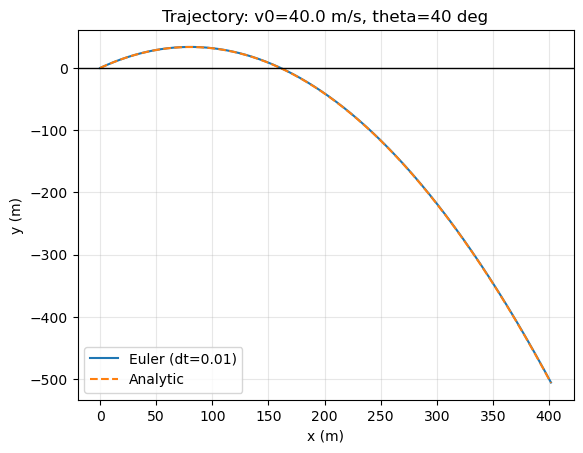

In [5]:

t_e, x_e, y_e, vx_e, vy_e = euler_projectile(vx0, vy0, y0=y0, dt=dt, t_max=t_max)
t_land_e, x_land_e = landing_by_linear_interpolation(t_e, y_e, x_e)

T_analytic = analytic_flight_time(vy0, y0)
R_analytic = vx0 * T_analytic
x_a, y_a = analytic_xy(vx0, vy0, y0, t_e)

print(f"Analytic flight time T ≈ {T_analytic:.5f} s")
print(f"Analytic range      R ≈ {R_analytic:.5f} m")
print(f"Euler landing: t ≈ {t_land_e:.5f} s, x ≈ {x_land_e:.5f} m (dt={dt})")

plt.figure()
plt.plot(x_e, y_e, label=f"Euler (dt={dt})")
plt.plot(x_a, y_a, '--', label="Analytic")
plt.axhline(0.0, lw=1, c='k')
plt.xlabel("x (m)"); plt.ylabel("y (m)")
plt.title(f"Trajectory: v0={v0} m/s, theta={theta_deg} deg")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()


## Timestep Sensitivity: Range Error vs Δt

,dt,x_land_euler,t_land_euler,R_analytic,range_error
0,0.500,175.609684,5.731054,160.62104,14.988644
1,0.200,166.712878,5.440705,160.62104,6.091837
2,0.100,163.671297,5.341443,160.62104,3.050256
3,0.050,162.151151,5.291832,160.62104,1.530110
4,0.020,161.233676,5.261890,160.62104,0.612636
5,0.010,160.927368,5.251894,160.62104,0.306328
6,0.005,160.774215,5.246896,160.62104,0.153175


Saved: euler_outputs/euler_range_error_summary.csv


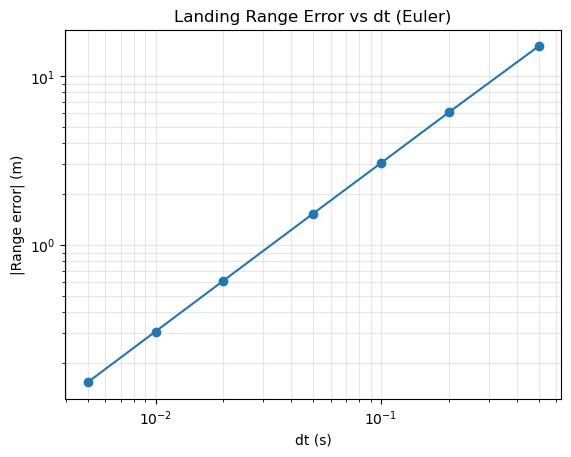

Saved: euler_outputs/range_error_vs_dt.png


In [6]:

dt_list = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005]
rows = []
for dt_i in dt_list:
    t_i, x_i, y_i, _, _ = euler_projectile(vx0, vy0, y0=y0, dt=dt_i, t_max=t_max)
    tL, xL = landing_by_linear_interpolation(t_i, y_i, x_i)
    rows.append({"dt": dt_i, "x_land_euler": xL, "t_land_euler": tL, "R_analytic": R_analytic,
                 "range_error": xL - R_analytic})

df = pd.DataFrame(rows).sort_values("dt", ascending=False)
display(df)

csv_path = os.path.join(OUTDIR, "euler_range_error_summary.csv")
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

plt.figure()
plt.loglog(df["dt"], np.abs(df["range_error"]), marker="o")
plt.xlabel("dt (s)"); plt.ylabel("|Range error| (m)")
plt.title("Landing Range Error vs dt (Euler)")
plt.grid(True, which="both", alpha=0.3)
png_path = os.path.join(OUTDIR, "range_error_vs_dt.png")
plt.savefig(png_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved:", png_path)


## Position Error vs Time

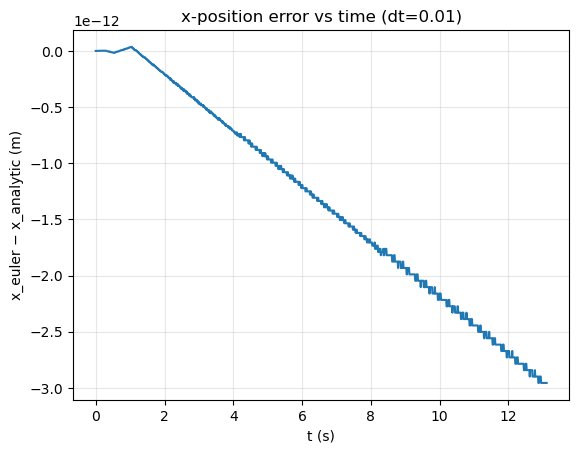

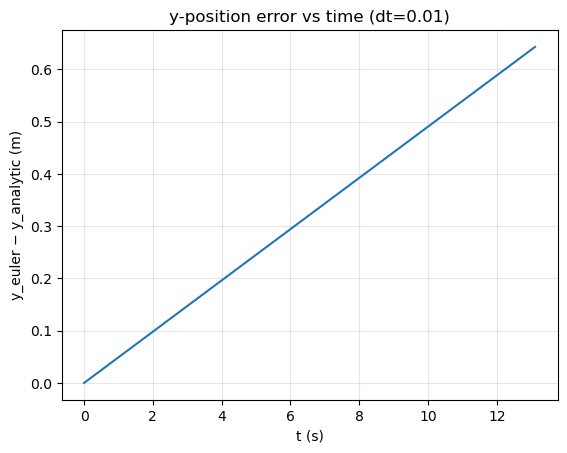

Saved: euler_outputs/dx_vs_time.png
Saved: euler_outputs/dy_vs_time.png


In [7]:

x_a, y_a = analytic_xy(vx0, vy0, y0, t_e)
dx = x_e - x_a
dy = y_e - y_a

plt.figure()
plt.plot(t_e, dx)
plt.xlabel("t (s)"); plt.ylabel("x_euler − x_analytic (m)")
plt.title(f"x-position error vs time (dt={dt})")
plt.grid(True, alpha=0.3)
png_dx = os.path.join(OUTDIR, "dx_vs_time.png")
plt.savefig(png_dx, dpi=150, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(t_e, dy)
plt.xlabel("t (s)"); plt.ylabel("y_euler − y_analytic (m)")
plt.title(f"y-position error vs time (dt={dt})")
plt.grid(True, alpha=0.3)
png_dy = os.path.join(OUTDIR, "dy_vs_time.png")
plt.savefig(png_dy, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", png_dx)
print("Saved:", png_dy)


## Velocity and Acceleration Components

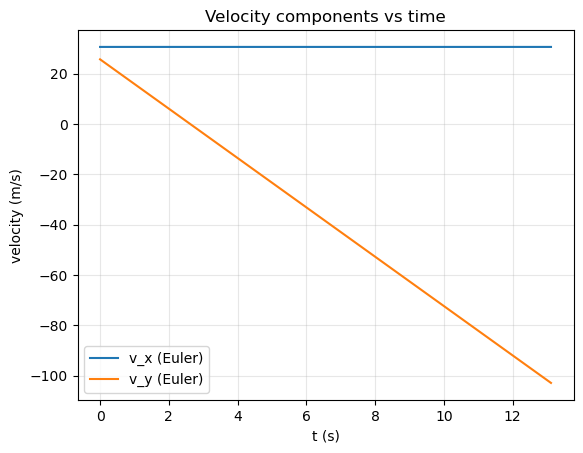

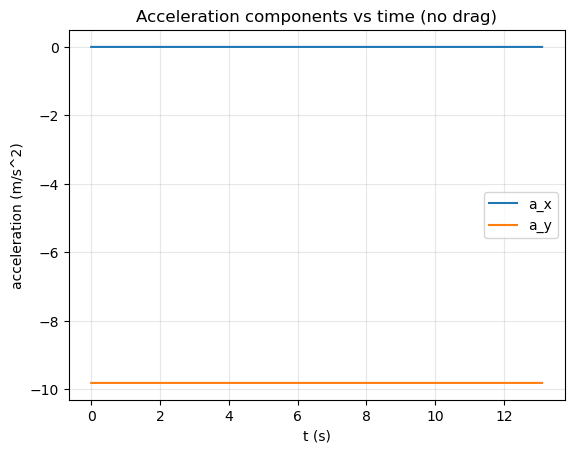

Saved: euler_outputs/velocity_components.png
Saved: euler_outputs/acceleration_components.png


In [8]:

ax_e = np.zeros_like(t_e)
ay_e = -g * np.ones_like(t_e)

plt.figure()
plt.plot(t_e, vx_e, label="v_x (Euler)")
plt.plot(t_e, vy_e, label="v_y (Euler)")
plt.xlabel("t (s)"); plt.ylabel("velocity (m/s)")
plt.title("Velocity components vs time")
plt.legend(); plt.grid(True, alpha=0.3)
png_vel = os.path.join(OUTDIR, "velocity_components.png")
plt.savefig(png_vel, dpi=150, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(t_e, ax_e, label="a_x")
plt.plot(t_e, ay_e, label="a_y")
plt.xlabel("t (s)"); plt.ylabel("acceleration (m/s^2)")
plt.title("Acceleration components vs time (no drag)")
plt.legend(); plt.grid(True, alpha=0.3)
png_acc = os.path.join(OUTDIR, "acceleration_components.png")
plt.savefig(png_acc, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", png_vel)
print("Saved:", png_acc)


## Mechanical Energy vs Time

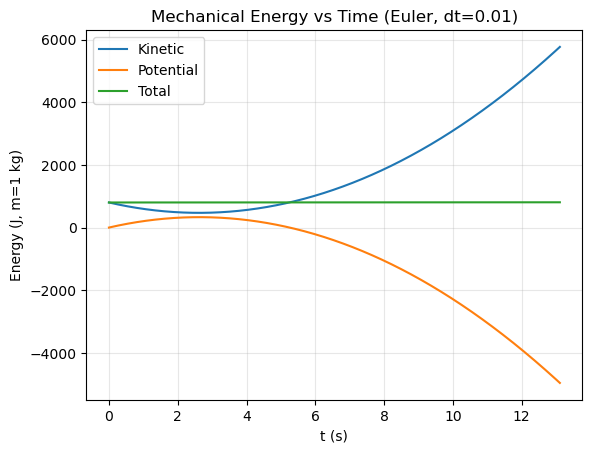

Saved: euler_outputs/energy_vs_time.png


In [9]:

m = 1.0
KE = 0.5 * m * (vx_e**2 + vy_e**2)
PE = m * g * y_e
E  = KE + PE

plt.figure()
plt.plot(t_e, KE, label="Kinetic")
plt.plot(t_e, PE, label="Potential")
plt.plot(t_e, E,  label="Total")
plt.xlabel("t (s)"); plt.ylabel("Energy (J, m=1 kg)")
plt.title(f"Mechanical Energy vs Time (Euler, dt={dt})")
plt.legend(); plt.grid(True, alpha=0.3)
png_energy = os.path.join(OUTDIR, "energy_vs_time.png")
plt.savefig(png_energy, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", png_energy)


## Observations

In [10]:

obs = """
**Key observations (example):**
- Landing range error |ΔR| decreases as dt shrinks (Euler is first-order).
- For dt around 0.02–0.01 s, the landing x is often a “pretty good” match.
- x(t) error tends to grow ~linearly; y(t) error can grow faster near landing.
- Explicit Euler does not conserve energy; smaller dt reduces the drift.
- Try varying v0 and theta and repeat the dt sweep; note stability of your “good” dt.
"""
print(obs.strip())

with open(os.path.join(OUTDIR, "observations.txt"), "w") as f:
    f.write(obs.strip() + "\n")
print("Saved:", os.path.join(OUTDIR, "observations.txt"))


**Key observations (example):**
- Landing range error |ΔR| decreases as dt shrinks (Euler is first-order).
- For dt around 0.02–0.01 s, the landing x is often a “pretty good” match.
- x(t) error tends to grow ~linearly; y(t) error can grow faster near landing.
- Explicit Euler does not conserve energy; smaller dt reduces the drift.
- Try varying v0 and theta and repeat the dt sweep; note stability of your “good” dt.
Saved: euler_outputs/observations.txt
